In [1]:
import glob
import os
import cv2
import glob
import importlib

import _pickle as pkl
import numpy as np
import pandas as pd

In [2]:
import analyze2p.utils as hutils
import analyze2p.plotting as pplot

import analyze2p.receptive_fields.utils as rfutils
import analyze2p.aggregate_datasets as aggr
import pylab as pl
import analyze2p.extraction.traces as traceutils

In [3]:
visual_areas=['V1', 'Lm', 'Li']
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


In [4]:
meta[(meta.visual_area=='Li') & (meta.experiment=='rfs')]

,experiment,visual_area,datakey,fov,animalid,session,fovnum
22,rfs,Li,20190522_JC089_fov1,FOV1_zoom2p0x,JC089,20190522,1
31,rfs,Li,20190602_JC091_fov1,FOV1_zoom2p0x,JC091,20190602,1
64,rfs,Li,20191017_JC113_fov1,FOV1_zoom2p0x,JC113,20191017,1


In [5]:
dk = '20191006_JC110_fov1'
va = 'V1'
#retinorun_2p='retino_run1'
traceid='traces001'

In [6]:
meta[meta.datakey==dk]

,experiment,visual_area,datakey,fov,animalid,session,fovnum
214,rfs,V1,20191006_JC110_fov1,FOV1_zoom2p0x,JC110,20191006,1
215,rfs10,V1,20191006_JC110_fov1,FOV1_zoom2p0x,JC110,20191006,1


In [7]:
# Soma RF data
experiment='rfs'
response_type='dff'
do_spherical_correction=False

fit_results, fit_params = rfutils.load_fit_results(dk, experiment=experiment,
                                    traceid=traceid, response_type=response_type,
                                    do_spherical_correction=do_spherical_correction)
print(len(fit_results.keys()))

229


## Test fit_rfs.py for NEUROPIL

In [8]:
importlib.reload(traceutils)

<module 'analyze2p.extraction.traces' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/extraction/traces.py'>

In [95]:
# Get raw traces
data_fpath = traceutils.get_data_fpath(dk, experiment_name=experiment,
                                      trace_type='np_subtracted')
print(data_fpath)

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_ecfb87_traces001_cdb8c9_traces001_af17f0_traces001_726304_traces001_81b1b5/data_arrays/np_subtracted.npz


In [83]:
# Soma raw traces
soma_traces, labels, sdf, run_info = aggr.load_dataset(data_fpath,
                                            trace_type='corrected')

In [128]:
# Neuropil traces (check this)
np_traces, labels, sdf, run_info = aggr.load_dataset(data_fpath,
                                            trace_type='corrected',
                                            is_neuropil=True)

KeysView(<numpy.lib.npyio.NpzFile object at 0x2ac66bf37f90>)


In [129]:
rid = 107
np_traces[rid].shape

(152460,)

In [130]:
%matplotlib notebook

<IPython.core.display.Javascript object>


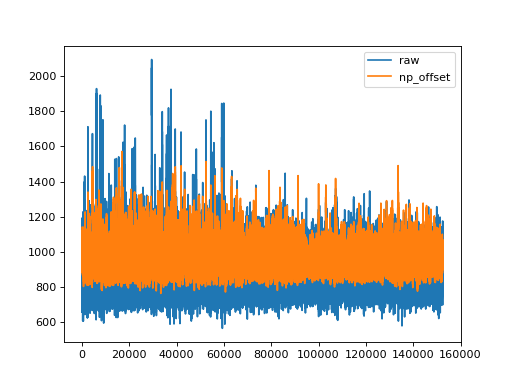

In [133]:
pl.figure()
#pl.plot(np_traces[rid], label='np')
pl.plot(soma_traces[rid], label='raw')
pl.plot(np_traces[rid], label='np_offset')

pl.legend()

In [135]:
ptraces_soma, trialdata_soma = aggr.process_traces(soma_traces, labels, 
                                response_type=fit_params['response_type'], 
                                nframes_post_onset=fit_params['nframes_post_onset'])    
trialdata_soma.shape

--- processed traces: dff


(2310, 392)

In [134]:
ptraces_np, trialdata_np = aggr.process_traces(np_traces, labels, 
                                response_type=fit_params['response_type'], 
                                nframes_post_onset=fit_params['nframes_post_onset'])    
trialdata_np.shape

--- processed traces: dff


(2310, 392)

<IPython.core.display.Javascript object>


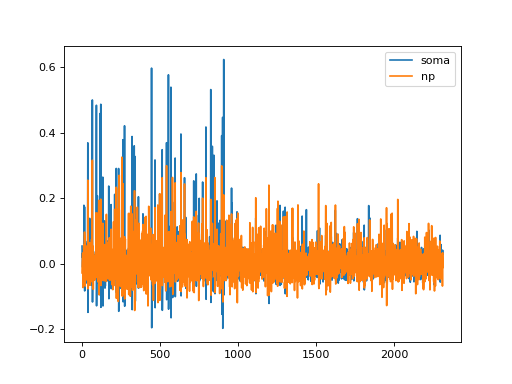

In [136]:
pl.figure()
pl.plot(trialdata_soma[rid], label='soma')
pl.plot(trialdata_np[rid], label='np')
pl.legend()

## Check maps

In [137]:
row_vals = fit_params['row_vals']
col_vals = fit_params['col_vals']
nx = len(col_vals)
ny = len(row_vals)

In [138]:
arr_np = rfutils.group_trial_values_by_cond(trialdata_np)
arr_soma = rfutils.group_trial_values_by_cond(trialdata_soma)

<IPython.core.display.Javascript object>


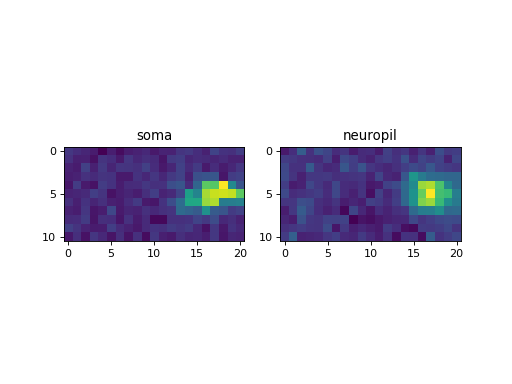

Text(0.5, 1.0, 'neuropil')

In [139]:
roimap_soma = rfutils.get_rf_map(arr_soma[rid].values, nx, ny)
roimap_np = rfutils.get_rf_map(arr_np[rid].values, nx, ny)

fig, axn = pl.subplots(1,2)
ax=axn[0]
ax.imshow(roimap_soma)
ax.set_title('soma')

ax=axn[1]
ax.imshow(roimap_np)
ax.set_title("neuropil")


<IPython.core.display.Javascript object>


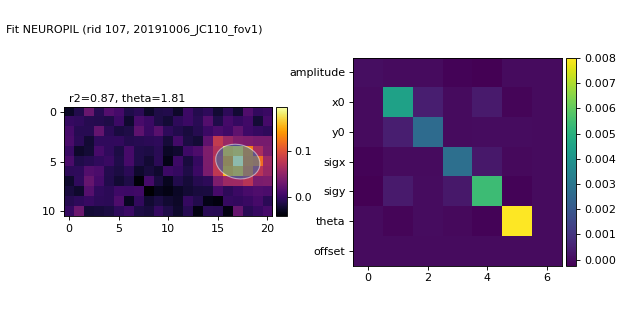

Text(0.01, 0.9, 'Fit NEUROPIL (rid 107, 20191006_JC110_fov1)')

In [143]:
res_np, fig = rfutils.plot_and_fit_roi_RF(arr_np[rid], row_vals, col_vals)

fig.text(0.01, 0.9, 'Fit NEUROPIL (rid %i, %s)' % (rid, dk))

<IPython.core.display.Javascript object>


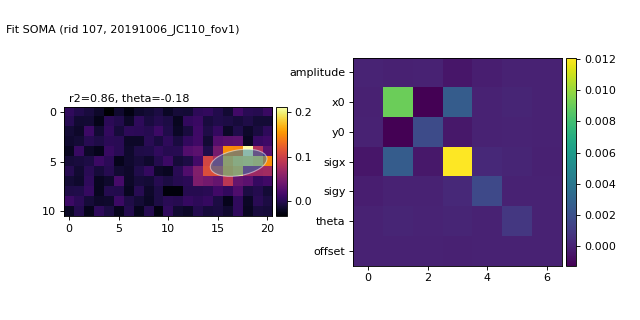

Text(0.01, 0.9, 'Fit SOMA (rid 107, 20191006_JC110_fov1)')

In [144]:
res_np, fig = rfutils.plot_and_fit_roi_RF(arr_soma[rid], row_vals, col_vals)
fig.text(0.01, 0.9, 'Fit SOMA (rid %i, %s)' % (rid, dk))

## Load NP receptive field fits

In [148]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [8]:
import h5py
import json
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.retinotopy.segment as seg

In [9]:
def get_masks(datakey, experiment='rfs', traceid='traces001'):

    session, animalid, fovnum = hutils.split_datakey_str(datakey)
    # Get reference file (from preprocessing)
    roiid = roiutils.get_roiid_from_traceid(animalid, session, 'FOV%i_*' % fovnum,
                                            run_type=experiment, traceid=traceid)
    rid_fpath = glob.glob(os.path.join(rootdir, animalid, session, 
                                       'ROIs', 'rids*.json'))[0]
    with open(rid_fpath, 'r') as f:
        rids = json.load(f)
    reffile = rids[roiid]['PARAMS']['options']['ref_file']
#     print(reffile)
    # Get mask paths
    mask_paths = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovnum,
                        '%s_*' % experiment, 'traces/%s*' % traceid, 'MASKS.hdf5'))
#     for r in mask_paths:
#         print(r)
    maskdict_path = mask_paths[0]
    try:
        MASKS = h5py.File(maskdict_path, 'r')
        # print(MASKS['File%03d' % reffile]['Slice01'].keys())
        # Get neuropil masks (for background calculation)
        zproj = MASKS['File%03d' % reffile]['Slice01']['zproj'][:]
        # Load soma masks to get "center"
        masks_soma = MASKS['File%03d' % reffile]['Slice01']['maskarray'][:].T
        d1, d2 = zproj.shape
        # ds_factor=2
        nrois_total, _ = masks_soma.shape
        masks_soma = np.reshape(masks_soma, (nrois_total, d1, d2))
        masks_soma[masks_soma>0] = 1
        #print("NP masks:", masks_soma.shape)
    except Exception as e:
        traceback.print_exc()
    finally:
        MASKS.close()
        
    return masks_soma, zproj

In [10]:
def dilate_masks(masks_soma, desired_radius_um=20):
    # Get pixel size
    pixel_size = hutils.get_pixel_size()
    #pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
    um_per_pixel = np.mean(pixel_size)
    #desired_radius_um = 40 #20.0 # 20.
    pixels2dilate = desired_radius_um/um_per_pixel
    #print(pixels2dilate)
    kernel_size = np.ceil(pixels2dilate+2) #21
    kernel = retutils.get_kernel(kernel_size)
    kernel_diam_um = (kernel.shape[0]*um_per_pixel)
    print("Dilation diameter (um): %.2f" % kernel_diam_um)
    dilated_masks = retutils.dilate_mask_centers(masks_soma.astype(float), 
                                                 kernel_size=kernel_size)
    return dilated_masks

In [26]:

def plot_results(sm_azim, sm_elev, axn=None):
    if axn is None:
        fig, axn = pl.subplots(1, 4, figsize=(7,3))
    az_min, az_max = np.nanmin(sm_azim['input']), np.nanmax(sm_azim['input'])
    el_min, el_max = np.nanmin(sm_elev['input']), np.nanmax(sm_elev['input'])
    plotn=0
    for ai, skey in enumerate(['smoothed', 'nan_filled']):
        ax=axn[plotn]
        if plotn==0:
            ax.set_title('Azimuth', loc='left')
        elif plotn==2:
            ax.set_title('Elevation', loc='left')
        im1 = azim_np.copy() if skey=='input' else sm_azim[skey].copy()
        ax.imshow(im1, cmap='Spectral', vmin=az_min, vmax=az_max)
        plotn+=1

        ax=axn[plotn]
        im2 = elev_np.copy() if skey=='input' else sm_elev[skey].copy()
        ax.imshow(im2, cmap='Spectral', vmin=el_min, vmax=el_max)
        plotn+=1
    pl.subplots_adjust(left=0.05, right=0.85, wspace=0.2, bottom=0.2, top=0.8)
    
    for ax in axn.flat:
        ax.axis('off')
    return 
        

In [14]:
rootdir = '/n/coxfs01/2p-data'

# datakey = '20191006_JC110_fov1'
#dk = '20190522_JC084_fov1'
experiment='rfs'
traceid='traces001'

response_type='dff'
is_neuropil=True
do_spherical_correction=False

fit_thr=0.5

In [15]:
dk = '20190522_JC084_fov1'
fit_results, fit_params = rfutils.load_fit_results(dk, experiment=experiment,
                                    traceid=traceid, response_type=response_type,
                                    is_neuropil=is_neuropil,
                                    do_spherical_correction=do_spherical_correction)
# print(len(fit_results.keys()))
fitdf_all = rfutils.rfits_to_df(fit_results, fit_params, 
                           convert_coords=True, scale_sigma=True)

In [14]:
n_fit = fitdf_all.shape[0]
fitdf = fitdf_all[fitdf_all['r2']>fit_thr].copy()
n_pass = fitdf.shape[0]
print("... %s, %i of %i fit rois pass thr (>%.2f)" % (dk, n_pass, n_fit, fit_thr))
roi_list = fitdf.index.tolist()
print(len(roi_list))

... 20190522_JC084_fov1, 260 of 260 fit rois pass thr (>0.50)


In [18]:
masks_soma, zproj = get_masks(dk, experiment=experiment, traceid=traceid)
dilated_masks = dilate_masks(masks_soma, desired_radius_um=20)

Dilation diameter (um): 23.10


In [20]:
ixs = np.sum(dilated_masks, axis=0)
ixs.min(), ixs.max()

(0.0, 3.0)

In [21]:
azim_ = np.array([dilated_masks[i]*v for i, v in enumerate(fitdf['x0'].values)])
azim_np = np.true_divide(np.nansum(azim_, axis=0), ixs)

elev_ = np.array([dilated_masks[i]*v for i, v in enumerate(fitdf['y0'].values)])
elev_np = np.true_divide(np.nansum(elev_, axis=0), ixs)

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [23]:
pixel_size = hutils.get_pixel_size()
#### Neuropil:  Transform 2p fov
azim_np_r = retutils.transform_2p_fov(azim_np, pixel_size, normalize=False)
elev_np_r = retutils.transform_2p_fov(elev_np, pixel_size, normalize=False)
print(azim_np_r.shape)

(1177, 972)


<IPython.core.display.Javascript object>


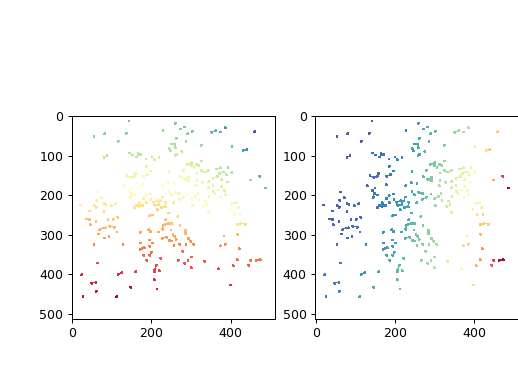

In [73]:
fig, axn = pl.subplots(1,2)
ax=axn[0]
ax.imshow(azim_np, cmap='Spectral')
ax=axn[1]
ax.imshow(elev_np, cmap='Spectral')

In [75]:
np.nanmin(azim_np), np.nanmax(azim_np)

(6.965987698075516, 29.531547236853072)

In [25]:
%matplotlib notebook

In [26]:
zproj_r = retutils.transform_2p_fov(zproj,
                     pixel_size, normalize=False) 

In [27]:
um_per_pix = np.mean(pixel_size)
target_sigma_um=21
smooth_fwhm = int(round(target_sigma_um/um_per_pix))
print(smooth_fwhm)

10


In [30]:
target_sigma_um=21
smooth_fwhm = int(round(target_sigma_um/um_per_pix))
print(smooth_fwhm)

10


In [32]:
import analyze2p.retinotopy.segment as seg

In [58]:
az_min, az_max = np.nanmin(azim_r), np.nanmax(azim_r)
el_min, el_max = np.nanmin(elev_r), np.nanmax(elev_r)

print(az_min, az_max)
print(el_min, el_max)

0.0 29.531547236853086
-43.0717046325862 0.0


In [59]:
import analyze2p.retinotopy.segment as seg

In [66]:
sm_azim, sm_elev = seg.smooth_maps(azim_np, elev_np, 
                            target_sigma_um=20, #smooth_fwhm=smooth_fwhm, 
                            smooth_spline=(1, 1), fill_nans=True,
                            smooth_spline_x=1, 
                            smooth_spline_y=1,
                            start_with_transformed=False, 
                            use_phase_smooth=False, ds_factor=1)

Target: 20 (fwhm=10, k=(1, 1))
start 6.965987698075516 29.531547236853072
smoothed 6.965987698075513 29.531547236853086
fillnan 6.965987698075513 29.531547236853086
fillnan 0.0 29.531547236853086


In [64]:
%matplotlib notebook

In [102]:
sm_azim.update({'input': azim_np})
sm_elev.update({'input': elev_np})


<IPython.core.display.Javascript object>


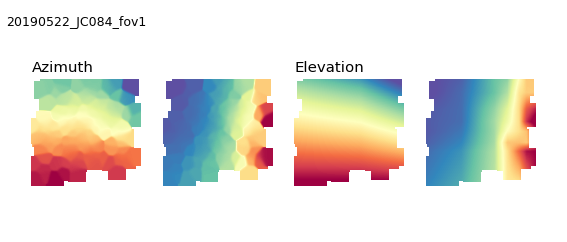

Text(0.01, 0.9, '20190522_JC084_fov1')

In [124]:
fig = plot_results(sm_azim, sm_elev)
fig.text(0.01, 0.9, dk)

<IPython.core.display.Javascript object>


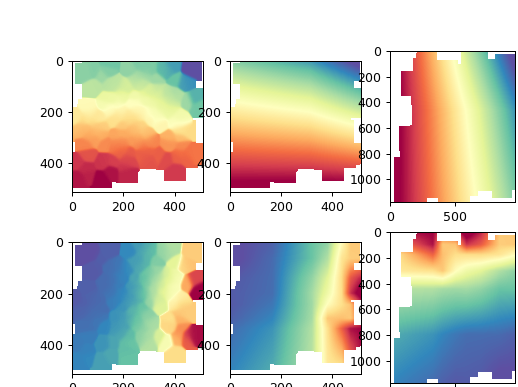

smoothed
nan_filled
final


In [101]:
az_min, az_max = np.nanmin(azim_np), np.nanmax(azim_np)
el_min, el_max = np.nanmin(elev_np), np.nanmax(elev_np)

fig, axn = pl.subplots(2,3)
for ai, skey in enumerate(['smoothed', 'nan_filled', 'final']):
    ax=axn[0, ai]
    print(skey)
    im1 = azim_np.copy() if skey=='input' else sm_azim[skey].copy()
    ax.imshow(im1, cmap='Spectral', vmin=az_min, vmax=az_max)

    ax=axn[1, ai]
    im2 = elev_np.copy() if skey=='input' else sm_elev[skey].copy()
    ax.imshow(im2, cmap='Spectral', vmin=el_min, vmax=el_max)

In [16]:
experiment='rfs'
va = 'V1'
meta['session_int'] = meta['session'].astype(int)

dsets = meta[(meta.experiment==experiment) & (meta.visual_area==va)
            & (meta['session_int']>20190511)].copy()
dsets

,experiment,visual_area,datakey,fov,animalid,session,fovnum,session_int
179,rfs,V1,20190512_JC083_fov1,FOV1_zoom2p0x,JC083,20190512,1,20190512
183,rfs,V1,20190517_JC083_fov1,FOV1_zoom2p0x,JC083,20190517,1,20190517
187,rfs,V1,20190522_JC084_fov1,FOV1_zoom2p0x,JC084,20190522,1,20190522
191,rfs,V1,20190613_JC097_fov1,FOV1_zoom2p0x,JC097,20190613,1,20190613
198,rfs,V1,20190616_JC097_fov1,FOV1_zoom2p0x,JC097,20190616,1,20190616
203,rfs,V1,20190617_JC097_fov1,FOV1_zoom2p0x,JC097,20190617,1,20190617
207,rfs,V1,20190622_JC085_fov1,FOV1_zoom2p0x,JC085,20190622,1,20190622
214,rfs,V1,20191006_JC110_fov1,FOV1_zoom2p0x,JC110,20191006,1,20191006


In [17]:
dk_list = dsets['datakey'].unique() #@[0::3]
print(dk_list)

['20190512_JC083_fov1' '20190517_JC083_fov1' '20190522_JC084_fov1'
 '20190613_JC097_fov1' '20190616_JC097_fov1' '20190617_JC097_fov1'
 '20190622_JC085_fov1' '20191006_JC110_fov1']


In [18]:
%matplotlib notebook

... 20190512_JC083_fov1, 288 of 288 fit rois pass thr (>0.50)
288
Dilation diameter (um): 23.10


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1108: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


Target: 20 (fwhm=10, k=(1, 1))
start 0.0 76.75921025679705
smoothed 0.0 74.5426572179964


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1168: UserWarning: ier=4062
  warnings.warn(message)
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:265: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:266: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


fillnan 0.0 74.5426572179964
fillnan 0.0 74.5426572179964


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1168: UserWarning: ier=4882
  warnings.warn(message)


<IPython.core.display.Javascript object>


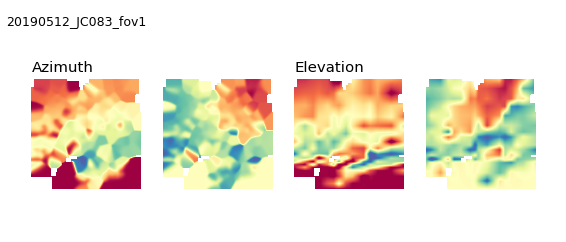

... 20190517_JC083_fov1, 205 of 205 fit rois pass thr (>0.50)
205
Dilation diameter (um): 23.10


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1108: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


Target: 20 (fwhm=10, k=(1, 1))
start 0.0 76.51365566021195
smoothed 0.0 76.51365566021198


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1168: UserWarning: ier=26070
  warnings.warn(message)
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:265: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:266: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


fillnan 0.0 76.51365566021198
fillnan 0.0 76.51365566021198


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1168: UserWarning: ier=3348
  warnings.warn(message)


<IPython.core.display.Javascript object>


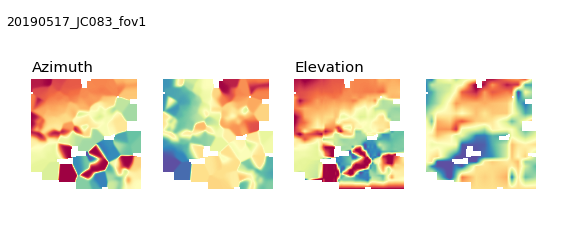

... 20190522_JC084_fov1, 260 of 260 fit rois pass thr (>0.50)
260
Dilation diameter (um): 23.10


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1108: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


Target: 20 (fwhm=10, k=(1, 1))
start 6.965987698075516 29.531547236853072
smoothed 6.965987698075513 29.531547236853086


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:265: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:266: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


fillnan 6.965987698075513 29.531547236853086
fillnan 0.0 29.531547236853086


<IPython.core.display.Javascript object>


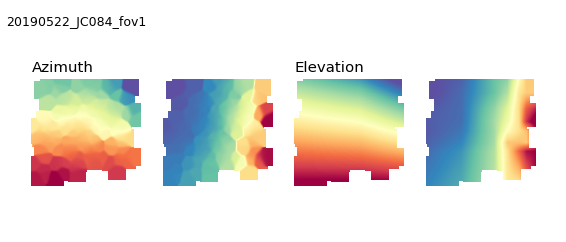

... 20190613_JC097_fov1, 225 of 225 fit rois pass thr (>0.50)
225
Dilation diameter (um): 23.10


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1108: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:265: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:266: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


Target: 20 (fwhm=10, k=(1, 1))
start 11.2255203378718 34.16940341600916
smoothed 11.227883647230612 34.169401513032234
fillnan 11.227883647230612 34.169401513032234
fillnan 0.0 34.169401513032234


<IPython.core.display.Javascript object>


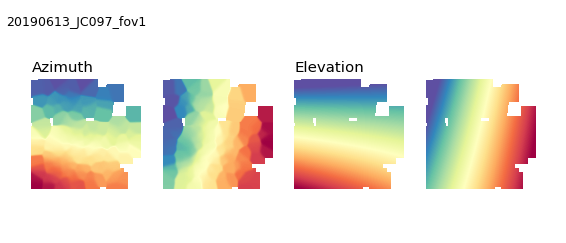

... 20190616_JC097_fov1, 432 of 432 fit rois pass thr (>0.50)
432
Dilation diameter (um): 23.10


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1108: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:265: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:266: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


Target: 20 (fwhm=10, k=(1, 1))
start 20.996951520158717 40.663847389255764
smoothed 21.049123115960146 40.66384738925578
fillnan 21.049123115960146 40.66384738925578
fillnan 0.0 40.66384738925578


<IPython.core.display.Javascript object>


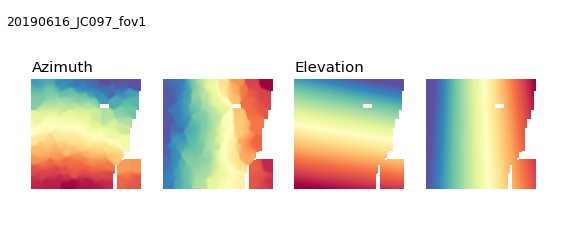

... 20190617_JC097_fov1, 438 of 438 fit rois pass thr (>0.50)
438
Dilation diameter (um): 23.10


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1108: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:265: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:266: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


Target: 20 (fwhm=10, k=(1, 1))
start 12.7284261624078 34.9959339627931
smoothed 12.728426162407796 34.9332685957932
fillnan 12.728426162407796 34.9332685957932
fillnan 0.0 34.9332685957932


<IPython.core.display.Javascript object>


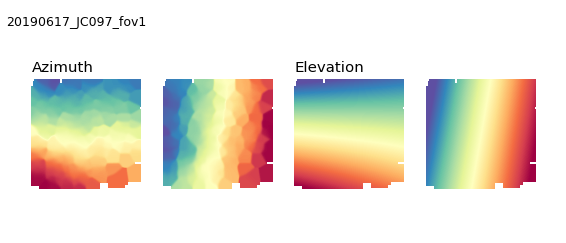

... 20190622_JC085_fov1, 389 of 389 fit rois pass thr (>0.50)
389
Dilation diameter (um): 23.10


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1108: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


Target: 20 (fwhm=10, k=(1, 1))
start 24.123641289191426 56.35676611193665
smoothed 24.350719659979685 56.35437582724048
fillnan 24.350719659979685 56.35437582724048
fillnan 0.0 56.35437582724048


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:265: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:266: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


<IPython.core.display.Javascript object>


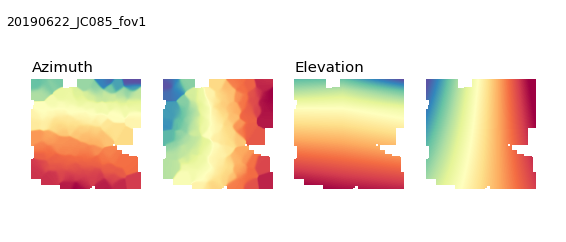

... 20191006_JC110_fov1, 376 of 385 fit rois pass thr (>0.50)
376
Dilation diameter (um): 23.10


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py:1108: RuntimeWarning: invalid value encountered in true_divide
  azim_smoothed = VV/WW


Target: 20 (fwhm=10, k=(1, 1))
start 0.0 40.80760860492198
smoothed 0.0 40.77963973355655


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:1168: UserWarning: ier=6479
  warnings.warn(message)
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:265: RuntimeWarning: invalid value encountered in less
  zfinal[znew<orig_min] = orig_min
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/segment.py:266: RuntimeWarning: invalid value encountered in greater
  zfinal[znew>orig_max] = orig_max


fillnan 0.0 40.77963973355655
fillnan 0.0 40.77963973355655


<IPython.core.display.Javascript object>


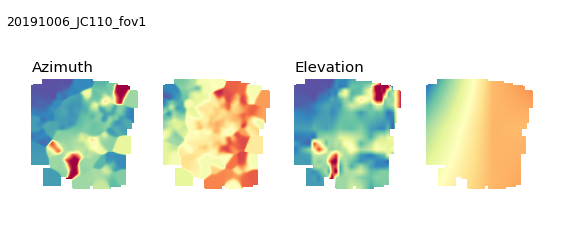

In [19]:
is_neuropil=True
MAPS = dict() #dict((k, ) for k in dk_list)
for dk in dk_list:
    try:
        fit_results, fit_params = rfutils.load_fit_results(dk, experiment=experiment,
                                traceid=traceid, response_type=response_type,
                                is_neuropil=is_neuropil,
                                do_spherical_correction=do_spherical_correction)
    except FileNotFoundError as e:
        print(" skipping %s" % dk)
        continue
    # print(len(fit_results.keys()))
    fitdf_all = rfutils.rfits_to_df(fit_results, fit_params, 
                               convert_coords=True, scale_sigma=True)
    n_fit = fitdf_all.shape[0]
    fitdf = fitdf_all[fitdf_all['r2']>fit_thr].copy()
    n_pass = fitdf.shape[0]
    print("... %s, %i of %i fit rois pass thr (>%.2f)" % (dk, n_pass, n_fit, fit_thr))
    roi_list = fitdf.index.tolist()
    print(len(roi_list))
    # Get masks
    masks_soma, zproj = get_masks(dk, experiment=experiment, traceid=traceid)
    dilated_masks = dilate_masks(masks_soma, desired_radius_um=20)
    ixs = np.sum(dilated_masks, axis=0)
    ixs.min(), ixs.max()
    # Get maps
    azim_ = np.array([dilated_masks[i]*v for i, v in enumerate(fitdf['x0'].values)])
    azim_np = np.true_divide(np.nansum(azim_, axis=0), ixs)
    elev_ = np.array([dilated_masks[i]*v for i, v in enumerate(fitdf['y0'].values)])
    elev_np = np.true_divide(np.nansum(elev_, axis=0), ixs)
    # Smmooth
    pixel_size = hutils.get_pixel_size()
    sm_azim, sm_elev = seg.smooth_maps(azim_np, elev_np, 
                                target_sigma_um=20, #smooth_fwhm=smooth_fwhm, 
                                smooth_spline=(1, 1), fill_nans=True,
                                smooth_spline_x=1, 
                                smooth_spline_y=1,
                                start_with_transformed=False, 
                                use_phase_smooth=False, ds_factor=1)

    sm_azim.update({'input': azim_np})
    sm_elev.update({'input': elev_np})
    fig = plot_results(sm_azim, sm_elev)
    fig.text(0.01, 0.9, dk)
    
    res = {'azim_orig': azim_np, 
           'azim_final': sm_azim['final'],
           'elev_orig': elev_np, 
           'elev_final': sm_elev['final'],
           'fitdf': fitdf}
    
    MAPS[dk] = res

In [37]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
basedir = os.path.join(aggregate_dir, 'receptive-fields', 'neuropil')
if not os.path.exists(basedir):
    os.makedirs(basedir)
    
tmp_masks_fpath = os.path.join(basedir, 'np_maps.pkl')
with open(tmp_masks_fpath, 'wb') as f:
    pkl.dump(MAPS, f, protocol=2)
    

In [25]:
len(MAPS.keys())

8

<IPython.core.display.Javascript object>


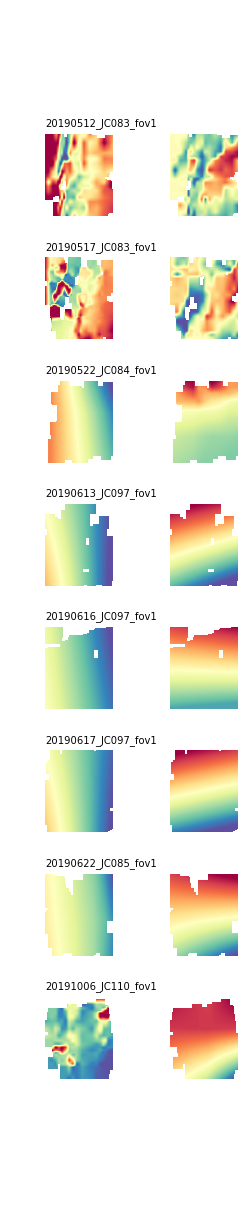

In [38]:
fig, axn = pl.subplots(len(MAPS.keys()), 2, figsize=(3,15))

for ai, dk in enumerate(MAPS.keys()):
    ax=axn[ai, 0]
    ax.imshow(MAPS[dk]['azim_final'], cmap='Spectral')
    ax.set_title(dk, loc='left', fontsize=8)
    
    ax=axn[ai, 1]
    ax.imshow(MAPS[dk]['elev_final'], cmap='Spectral')

for ax in axn.flat:
    ax.axis('off')
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.9, 
                   hspace=0.5, wspace=0.2)

pl.savefig(os.path.join(basedir, 'np_maps_V1.png'))


In [27]:
MAPS[dk].keys()

dict_keys(['azim_orig', 'azim_final', 'elev_orig', 'elev_final', 'fitdf'])

## Calculate gradient from TILES map

In [ ]:
import seaborn as sns

In [39]:
def align_cortex_to_gradient(df, gvectors, xlabel='ml_pos', ylabel='ap_pos'):
    # Transform predicted-ctx pos back to FOV coords
    u1 = (gvectors['az'])
    u2 = (gvectors['el'])
    # Cartesian normal (plus error)
    o1 = np.array([1, 0]) + np.finfo(np.float32).eps
    o2 = np.array([0, 1]) + np.finfo(np.float32).eps
    print(o1, o2)

    # X-axis
    T1 = roiutils.get_transformation_matrix(u1, o2)
    transf_x = [T1.dot(np.array([x, y])) for (x,y) \
                        in df[['ml_pos', 'ap_pos']].values]
    proj_ctx_x = np.array([p[0] for p in transf_x])

    T2 = roiutils.get_transformation_matrix(o1, u2)
    transf_y = [T2.dot(np.array([x, y])) for (x,y) \
                        in df[['ml_pos', 'ap_pos']].values]
    proj_ctx_y = np.array([p[1] for p in transf_y])
    
    new_xlabel = '%s_proj' % xlabel.split('_')[0]
    new_ylabel = '%s_proj' % ylabel.split('_')[0]
    df_ = pd.DataFrame({new_xlabel: proj_ctx_x, 
                  new_ylabel: proj_ctx_y}, index=df.index)
    
    return df_

In [40]:
# predicted_rf_locs = slope*proj_locs + intercept
# predicted_ctx_locs = (actual_rf_locs - intercept) / slope
def predict_cortex_position(regr, cond='az', points=None):
    g_intercept = float(regr[regr.cond==cond]['intercept'])
    g_slope = float(regr[regr.cond==cond]['coefficient'])
    predicted_ctx_x = (points - g_intercept) / g_slope

    return predicted_ctx_x

def predict_retino_position(regr, cond='az', points=None):
    g_intercept = float(regr[regr.cond==cond]['intercept'])
    g_slope = float(regr[regr.cond==cond]['coefficient'])
    predicted_ret_x = (points * g_slope) + g_intercept

    return predicted_ret_x

In [165]:
# Select datas
# dk = '20190617_JC097_fov1'
# dk = '20190522_JC084_fov1'
dk = '20191006_JC110_fov1'
# ---------------------------------------------------------
az_map = MAPS[dk]['azim_final'].copy()
el_map = MAPS[dk]['elev_final'].copy()
fitdf = MAPS[dk]['fitdf'].copy()

In [166]:
# Calculate gradient from TILES
grad_az = seg.image_gradient(az_map)
grad_el = seg.image_gradient(el_map)

<IPython.core.display.Javascript object>


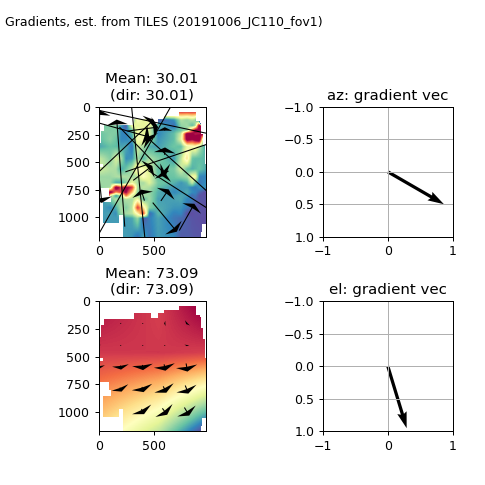

In [167]:
# Check gradient
spacing =200
scale = 0.0001 #0.0001
width = 0.01 #1 #0.01
headwidth=20

fig, axn = pl.subplots(2,2, figsize=(6,6))
for ai, cond in enumerate(['az', 'el']):
    ax=axn[ai,0]
    npmap = az_map.copy() if cond=='az' else el_map.copy()
    im = ax.imshow(npmap, cmap='Spectral')
    grad_ = grad_az.copy() if cond=='az' else grad_el.copy()
    seg.plot_gradients(grad_, ax=ax, draw_interval=spacing, 
                       scale=scale, width=width, headwidth=headwidth)
    ax= axn[ai,1]
    ax.grid(True)
    vhat_ = grad_['vhat'].copy()
    ax.quiver(0,0, vhat_[0], vhat_[1],  scale=1, scale_units='xy',
              units='xy', angles='xy', width=.05, pivot='tail')
    ax.set_aspect('equal')
    ax.set_ylim([-1, 1])
    ax.set_xlim([-1, 1])
    ax.set_title("%s: gradient vec" % cond)
    ax.invert_yaxis()

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.5, top=0.8)
fig.text(0.01, 0.95, 'Gradients, est. from TILES (%s)' % dk)

figname = 'np_gradients_%s' % dk
pl.savefig(os.path.join(basedir, '%s.svg' % dk))

In [168]:
# Load soma fits
fit_results, fit_params = rfutils.load_fit_results(dk, experiment=experiment,
                        traceid=traceid, response_type=response_type,
                        is_neuropil=False,
                        do_spherical_correction=do_spherical_correction)
fitdf_all = rfutils.rfits_to_df(fit_results, fit_params, 
                                convert_coords=True, scale_sigma=True)
n_fit = fitdf_all.shape[0]
fitdf = fitdf_all[fitdf_all['r2']>fit_thr].copy()
# Add position info
fitdf['datakey'] = dk
fitdf['visual_area'] = va
fitdf['experiment'] = experiment
fitdf['cell'] = fitdf.index.tolist()
rfdf = aggr.add_roi_positions(fitdf)

Adding ROI position info...


In [169]:
gvectors_TILES = {'az': grad_az['vhat'], 'el': grad_el['vhat']}

In [170]:
# Align CTX to GRADIENT (RFS)
projdf = align_cortex_to_gradient(rfdf, gvectors_TILES, 
                                  xlabel='ml_pos', ylabel='ap_pos')
df_tiles = pd.concat([rfdf, projdf], axis=1)

[1.00000012e+00 1.19209290e-07] [1.19209290e-07 1.00000012e+00]


<IPython.core.display.Javascript object>


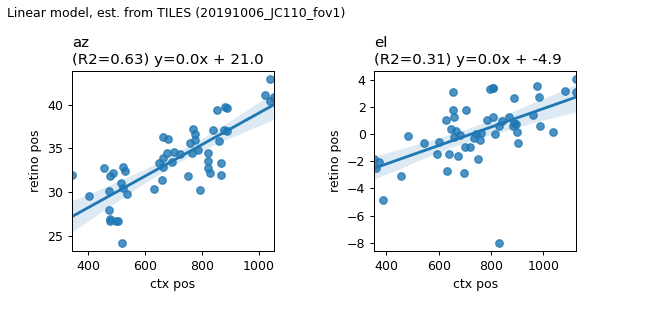

~~~regr results: y = 0.02 + 20.98 (R2=0.63)
~~~regr results: y = 0.01 + -4.91 (R2=0.31)


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [171]:
# Calculate LINEAR REGR from RFs
%matplotlib notebook
fig, axn = pl.subplots(1,2, figsize=(8,4))

r_=[]
for ai, cond in enumerate(['az', 'el']):
    ax=axn[ai]
    ctx_label = 'ml' if cond=='az' else 'ap'
    ret_label = 'x0' if cond=='az' else 'y0'

    xvs = df_tiles['%s_proj' % ctx_label].values
    yvs = df_tiles['%s' % ret_label].values
    regr_, linmodel = rfutils.do_linear_fit(xvs, yvs)
    regr_['cond'] = cond
    r_.append(regr_)
    
    sns.regplot(xvs, yvs, ax=ax)
    fit_str = '(R2=%.2f) y=%.1fx + %.1f' \
            % (regr_['R2'], regr_['coefficient'], regr_['intercept'])
    ax.set_title('%s\n%s' %(cond, fit_str), loc='left', fontsize=12)
    
    ax.set_ylabel('retino pos')
    ax.set_xlabel('ctx pos')
regr_tiles = pd.concat(r_)

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3, hspace=0.5, top=0.8,
                  wspace=0.5)
fig.text(0.01, 0.95, 'Linear model, est. from TILES (%s)' % dk)

figname = 'np_linmodel_%s' % dk
pl.savefig(os.path.join(basedir, '%s.svg' % dk))

In [172]:
# Predict RETINO from CTX position -- TILES
for ai, cond in enumerate(['az', 'el']):
    ctx_label = 'ml' if cond=='az' else 'ap'
    ret_label = 'x0' if cond=='az' else 'y0'
    p_x = predict_retino_position(regr_tiles, cond=cond, 
                              points=df_tiles['%s_proj' % ctx_label].values)
    df_tiles['predicted_%s' % ret_label] = p_x

##### ... and, compare to MOVINGBAR

#### Load MODEL - retino

In [173]:
# retinodf['ap_proj'] = ''
retinorun='retino'
session, animalid, fovnum = hutils.split_datakey_str(dk)

In [174]:
sdata[(sdata.visual_area==va) & (sdata.datakey==dk)
     & (sdata.experiment=='retino')]

,experiment,visual_area,datakey,fov,animalid,session,fovnum
218,retino,V1,20191006_JC110_fov1,FOV1_zoom2p0x,JC110,20191006,1


In [175]:
print(dk)

retinorun='retino_run'

20191006_JC110_fov1


In [176]:
proj_results = 'vectors'
fpaths = [f for f in glob.glob(os.path.join(rootdir, animalid, 
            session, 'FOV%i_*' % fovnum, 'retino*',#% retinorun, 
            'retino_analysis/retino_structure', 
            '%s_*.pkl' % (proj_results))) if '_pixels_thr' not in f] 
for fp in fpaths:
    print(fp)

fpath = fpaths[-1]
with open(fpath, 'rb') as f:
    gvectors_BAR = pkl.load(f, encoding='latin1')
gvectors_BAR.keys()

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/retino_structure/vectors_V1.pkl


dict_keys(['el', 'az'])

In [177]:
retinorun = os.path.split(fpath.split('/retino_analysis')[0])[-1]
retinorun

'retino_run1'

In [178]:
# Load LIN MODEL - moving bar
proj_results = 'projections'
fpaths = [f for f in glob.glob(os.path.join(rootdir, animalid, 
            session, 'FOV%i_*' % fovnum, '%s*' % retinorun, 
            'retino_analysis/retino_structure', 
            '%s_*.pkl' % (proj_results))) if '_pixels_thr' not in f] 
for fp in fpaths:
    print(fp)
fpath = fpaths[-1]
with open(fpath, 'rb') as f:
    presults = pkl.load(f, encoding='latin1')
regr_bar = presults['regr_df'].copy()
print(regr_bar.to_markdown())

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/retino_run1/retino_analysis/retino_structure/projections_V1.pkl
|    |       R2 |    RMSE |   coefficient | cond   |   intercept |   pearson_p |   pearson_r |
|---:|---------:|--------:|--------------:|:-------|------------:|------------:|------------:|
|  0 | 0.886529 | 1.78109 |    0.0178011  | az     |     19.8711 |           0 |    0.941557 |
|  1 | 0.810955 | 1.46739 |    0.00932511 | el     |    -10.7693 |           0 |    0.90053  |


In [179]:
regr_bar

,R2,RMSE,coefficient,cond,intercept,pearson_p,pearson_r
0,0.886529,1.781086,0.017801,az,19.871119,0.0,0.941557
1,0.810955,1.467389,0.009325,el,-10.769289,0.0,0.900530


In [180]:
# Align CTX to GRADIENT -- use MOVINGBAR
projdf = align_cortex_to_gradient(rfdf, gvectors_BAR, 
                                  xlabel='ml_pos', ylabel='ap_pos')
df_tiles_to_bar = pd.concat([rfdf, projdf], axis=1)

for ai, cond in enumerate(['az', 'el']):
    ctx_label = 'ml' if cond=='az' else 'ap'
    ret_label = 'x0' if cond=='az' else 'y0'
    p_x = predict_retino_position(regr_bar, cond=cond, 
                              points=df_tiles_to_bar['%s_proj' % ctx_label].values)
    df_tiles_to_bar['predicted_%s' % ret_label] = p_x
    
df_tiles_to_bar['residuals_x0'] = df_tiles_to_bar['x0']-df_tiles_to_bar['predicted_x0']
df_tiles_to_bar['residuals_y0'] = df_tiles_to_bar['y0']-df_tiles_to_bar['predicted_y0']

[1.00000012e+00 1.19209290e-07] [1.19209290e-07 1.00000012e+00]


<IPython.core.display.Javascript object>


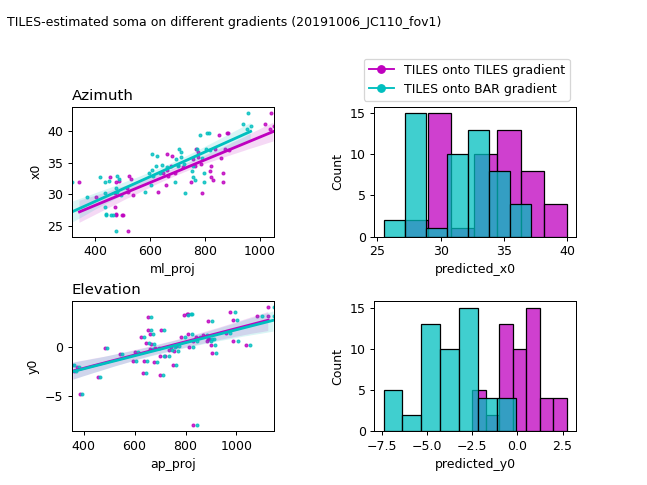

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

In [181]:
c1='m'
c2='c'
fig, axn = pl.subplots(2,2, figsize=(8,6))
ax=axn[0,0]
ax.set_title('Azimuth', loc='left')
sns.regplot('ml_proj', 'x0', data=df_tiles, ax=ax, scatter_kws={'s':5},
            color=c1)
sns.regplot('ml_proj', 'x0', data=df_tiles_to_bar, ax=ax, scatter_kws={'s':5},
            color=c2)
ax=axn[0,1]
sns.histplot(df_tiles['predicted_x0'], ax=ax, color=c1)
sns.histplot(df_tiles_to_bar['predicted_x0'], ax=ax, color=c2)

ax=axn[1,0]
ax.set_title('Elevation', loc='left')
sns.regplot('ap_proj', 'y0', data=df_tiles, ax=ax, scatter_kws={'s':5}, 
            color=c1)
sns.regplot('ap_proj', 'y0', data=df_tiles_to_bar, ax=ax, scatter_kws={'s':5}, 
            color=c2)
ax=axn[1,1]
sns.histplot(df_tiles['predicted_y0'], ax=ax, color=c1)
sns.histplot(df_tiles_to_bar['predicted_y0'], ax=ax, color=c2)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.5, hspace=0.5)

leg_h = pplot.custom_legend_markers(colors=[c1, c2],
                                    labels=['TILES onto TILES gradient',
                                           'TILES onto BAR gradient'])
axn[0, 1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='lower right')

fig.text(0.01, 0.95, 'TILES-estimated soma on different gradients (%s)' % dk)

figname = 'tiles_soma_on_tile_vs_bar__%s' % dk
pl.savefig(os.path.join(basedir, '%s.svg'))

In [182]:
importlib.reload(retutils)

<module 'analyze2p.retinotopy.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/retinotopy/utils.py'>

In [183]:
def load_movingbar_results(dk, retinorun):
    # load retinodata
    retinoid, RETID = retutils.load_retino_analysis_info(
                        dk, run=retinorun, use_pixels=False)
    data_id = '_'.join([dk, retinorun, retinoid])
    print("DATA ID: %s" % data_id)
    scaninfo = retutils.get_protocol_info(dk, run=retinorun)

    # Image dimensions
    d2_orig = scaninfo['pixels_per_line']
    d1_orig = scaninfo['lines_per_frame']
    print("Original dims: [%i, %i]" % (d1_orig, d2_orig))
    ds_factor = int(RETID['PARAMS']['downsample_factor'])
    print('Data were downsampled by %i.' % ds_factor)
    # Get pixel size
    pixel_size = hutils.get_pixel_size()
    pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
    d1 = int(d1_orig/ds_factor)
    d2 = int(d2_orig/ds_factor)
    print(d1, d2)

    # Load fft 
    fft_results = retutils.load_fft_results(dk,
                                    retinorun=retinorun, traceid=traceid, 
                                    rootdir=rootdir, create_new=False,
                                    use_pixels=False)
    fft_soma = fft_results['fft_soma']
    fft_np = fft_results['fft_neuropil']
    # Create dataframe of magratios -- each column is a condition
    magratios_soma, phases_soma = retutils.extract_from_fft_results(fft_soma)
    magratios_np, phases_np = retutils.extract_from_fft_results(fft_np)
    dims = (d1_orig, d2_orig)
    
    return magratios_soma, phases_soma, magratios_np, phases_np, dims

In [184]:
retinorun

'retino_run1'

In [185]:
mags_soma, phases_soma, mags_np, phases_np, dims = load_movingbar_results(dk, 
                                                                          retinorun)


DATA ID: 20191006_JC110_fov1_retino_run1_analysis002
Original dims: [512, 512]
Data were downsampled by 2.
256 256


In [186]:
magthr_2p=0.001
delay_map_thr=1.0
ds_factor=2
# #### Get maps
# abs_vmin, abs_vmax = (-np.pi, np.pi)
mvb_soma = retutils.get_final_maps(mags_soma, phases_soma, 
                    trials_by_cond=None,
                    mag_thr=magthr_2p, dims=dims,
                    ds_factor=ds_factor, use_pixels=False)

In [187]:
# Add position info
mvb_soma['datakey'] = dk
mvb_soma['visual_area'] = va
mvb_soma['experiment'] = experiment
mvb_soma['cell'] = mvb_soma.index.tolist()
ret_ = aggr.add_roi_positions(mvb_soma)

Adding ROI position info...


In [188]:
ret_.head()

,phase_az,phase_el,mag_az,mag_el,datakey,visual_area,experiment,cell,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,1.755200,-0.063843,0.032374,0.027805,20191006_JC110_fov1,V1,rfs,0,JC110,FOV1_zoom2p0x,20191006,318.021135,138,11.422309,6,961.377691,859.578865
1,NaN,NaN,0.008960,0.016142,20191006_JC110_fov1,V1,rfs,1,JC110,FOV1_zoom2p0x,20191006,285.758121,124,51.400391,27,921.399609,891.841879
2,1.814990,0.213110,0.013967,0.011810,20191006_JC110_fov1,V1,rfs,2,JC110,FOV1_zoom2p0x,20191006,281.149119,122,38.074364,20,934.725636,896.450881
3,1.901386,0.011366,0.018860,0.010719,20191006_JC110_fov1,V1,rfs,3,JC110,FOV1_zoom2p0x,20191006,225.841096,98,53.304110,28,919.495890,951.758904
4,1.748735,-0.156081,0.043288,0.033929,20191006_JC110_fov1,V1,rfs,4,JC110,FOV1_zoom2p0x,20191006,251.190607,109,51.400391,27,921.399609,926.409393


In [189]:
# ret_ = pd.concat([centroids, mvb_soma], axis=1)

In [190]:
magthr_2p=0.02
pass_mag_rois = ret_[(ret_.mag_az>magthr_2p) 
                      & (ret_.mag_el>magthr_2p)].index.tolist()
retinodf = ret_.loc[pass_mag_rois]

In [191]:
screen2p_x = 119.5564
screen2p_y = 67.323
resolution2p = [1920, 1080] #[1024, 768]
abs_vmin, abs_vmax = (-np.pi, np.pi)

lmax_az_2p = screen2p_x #/2.
lmin_az_2p = 0 #-screen2p_x #-lmax_az_2p
lmax_el_2p = screen2p_y #/2.
lmin_el_2p = 0 #-screen2p_y# 0 #-lmax_el_2p

retinodf['az_lin'] = hutils.convert_range(retinodf['phase_az'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)
retinodf['el_lin'] = hutils.convert_range(retinodf['phase_el'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)

retinodf['x0'] = retinodf['az_lin'] - (lmax_az_2p/2.)
retinodf['y0'] = retinodf['el_lin'] - (lmax_az_2p/2.)

In [192]:
retinodf.head()

,phase_az,phase_el,mag_az,mag_el,datakey,visual_area,experiment,cell,animalid,fov,...,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,az_lin,el_lin,x0,y0
0,1.755200,-0.063843,0.032374,0.027805,20191006_JC110_fov1,V1,rfs,0,JC110,FOV1_zoom2p0x,...,318.021135,138,11.422309,6,961.377691,859.578865,93.176122,58.563391,33.397922,-1.214809
4,1.748735,-0.156081,0.043288,0.033929,20191006_JC110_fov1,V1,rfs,4,JC110,FOV1_zoom2p0x,...,251.190607,109,51.400391,27,921.399609,926.409393,93.053114,56.808283,33.274914,-2.969917
18,1.920005,0.141740,0.029623,0.021055,20191006_JC110_fov1,V1,rfs,18,JC110,FOV1_zoom2p0x,...,147.488063,64,112.319374,59,860.480626,1030.111937,96.312038,62.475231,36.533838,2.697031
19,1.770000,0.061891,0.020579,0.021825,20191006_JC110_fov1,V1,rfs,19,JC110,FOV1_zoom2p0x,...,165.924070,72,112.319374,59,860.480626,1011.675930,93.457747,60.955861,33.679547,1.177661
22,1.832216,-0.015184,0.025589,0.025187,20191006_JC110_fov1,V1,rfs,22,JC110,FOV1_zoom2p0x,...,103.702544,45,123.741683,65,849.058317,1073.897456,94.641587,59.489286,34.863387,-0.288914


In [193]:
# Align CTX to GRADIENT (RFS)
retino_proj = align_cortex_to_gradient(retinodf, gvectors_BAR, 
                                  xlabel='ml_pos', ylabel='ap_pos')
df_bar = pd.concat([retinodf, retino_proj], axis=1)

[1.00000012e+00 1.19209290e-07] [1.19209290e-07 1.00000012e+00]


In [194]:
# Predict retino position from cortical position
for ai, cond in enumerate(['az', 'el']):
    ctx_label = 'ml' if cond=='az' else 'ap'
    ret_label = 'x0' if cond=='az' else 'y0'
    p_x = predict_retino_position(regr_bar, cond=cond, 
                              points=df_bar['%s_proj' % ctx_label].values)
    df_bar['predicted_%s' % ret_label] = p_x


In [195]:
df_tiles['residuals_x0'] = df_tiles['x0'] - df_tiles['predicted_x0']
df_tiles['residuals_y0'] = df_tiles['y0'] - df_tiles['predicted_y0']

df_bar['residuals_x0'] = df_bar['x0'] - df_bar['predicted_x0']
df_bar['residuals_y0'] = df_bar['y0'] - df_bar['predicted_y0']


<IPython.core.display.Javascript object>


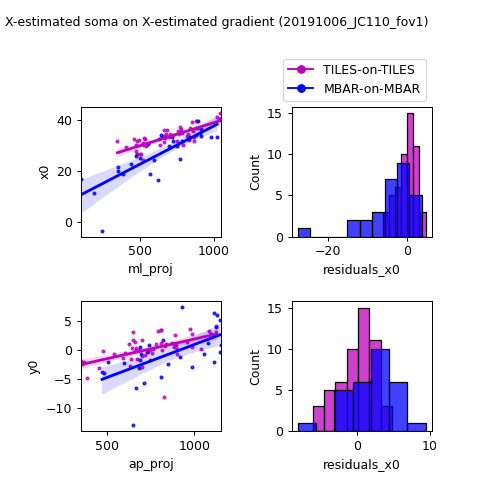

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

In [196]:
c1='m'
c2='b'
labels = ['TILES-on-TILES', 'MBAR-on-MBAR']
fig, axn = pl.subplots(2,2, figsize=(6,6))
ax=axn[0, 0]
sns.regplot('ml_proj', 'x0', data=df_tiles, ax=ax, color=c1,
           scatter_kws={'s':5})
ax=axn[0, 0]
sns.regplot('ml_proj', 'x0', data=df_bar, ax=ax, color=c2,
           scatter_kws={'s':5})
ax=axn[0,1]
sns.histplot(df_tiles['residuals_x0'], ax=ax, label='x0', color=c1)
sns.histplot(df_bar['residuals_x0'], ax=ax, label='y0', color=c2)

ax=axn[1, 0]
sns.regplot('ap_proj', 'y0', data=df_tiles, ax=ax, color=c1,
           scatter_kws={'s':5})
ax=axn[1, 0]
sns.regplot('ap_proj', 'y0', data=df_bar, ax=ax, color=c2,
           scatter_kws={'s':5})
ax=axn[1,1]
sns.histplot(df_tiles['residuals_x0'], ax=ax, label='x0', color=c1)
sns.histplot(df_bar['residuals_y0'], ax=ax, label='y0', color=c2)

pl.subplots_adjust(left=0.15, right=0.8, bottom=0.2, top=0.8, wspace=0.5, hspace=0.5)

leg_h = pplot.custom_legend_markers(colors=[c1, c2],
                                    labels=labels)
axn[0, 1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='lower right')

fig.text(0.01, 0.95, 'X-estimated soma on X-estimated gradient (%s)' % dk)

figname = 'like_with_like__%s' % dk
pl.savefig(os.path.join(basedir, '%s.svg' % figname))
